In [63]:
import json
from nltk.stem.snowball import SnowballStemmer
import re
import string
import spacy
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

1. (opțional) Întrucît setul de date conține multe categorii, puteți păstra doar exemple din 4-5 clase (selectate de voi) și să rezolvați problema de clasificare doar pentru aceste exemple.

In [4]:
categories = ['SPORTS', 'BLACK VOICES', 'PARENTS', 'COMEDY', 'BUSINESS']
cat_list = []
with open ("News_Category_Dataset_v3.json", "r") as file:
    while True:
        line = file.readline()
        if line is None or line == '':
            break
        json_line = json.loads(line)
        if json_line['category'] not in categories:
            continue
        cat_list.append(json_line)



2. Încercați mai multe metode de preprocesare și tokenizare a textelor pentru a obține reprezentări de tip Bag-of-Words (ștergeti/nu ștergeti stop words, lematizați sau aplicați stemming, păstrați sau eliminați punctuația, normalizați folosind standardizare, L1, L2 sau Tf-Idf). Implementați **3** astfel de combinații.

In [56]:
stemmer = SnowballStemmer(language='romanian')
def stemming(word):
    return stemmer.stem(word)


def preprocess(word, steam=False):
    if steam:
        return stemming(word.lower())
    return word.lower()


def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

nlp = spacy.load("en_core_web_md")
def remove_stopwords(text):
    no_stopwords = []
    for token in text:
        if token.text not in nlp.Defaults.stop_words and token.text != ' ':
            no_stopwords.append(token)
    return no_stopwords

def lemmatization(text):
    return [token.lemma for token in text]

def tokenize(text, punctuation=False, stopwords=False, lemma=False):

    text = re.sub(r'http\S+|www\S+', '', text)
    if punctuation:
        text = remove_punctuation(text)
    text = nlp(text)
    if stopwords:
        text = remove_stopwords(text)
    if lemma:
        text = lemmatization(text)

    return text


def bow (method='1'):
    cv = None
    if method == '1':
        cv = CountVectorizer(
            preprocessor=lambda z: preprocess(z),
            tokenizer=lambda z: tokenize(z, punctuation=True, stopwords=True, lemma=True),
            token_pattern=None,
            max_features=10
        )
    elif method == '2':
        cv = CountVectorizer(
            preprocessor=lambda z: preprocess(z),
            tokenizer=lambda z: tokenize(z, punctuation=True, stopwords=False, lemma=True),
            token_pattern=None,
            max_features=10
        )
    elif method == '3':
        cv = CountVectorizer(
            preprocessor=lambda z: preprocess(z, True),
            tokenizer=lambda z: tokenize(z, punctuation=True, stopwords=False, lemma=False),
            token_pattern=None,
            max_features=10
        )

    x, y = None, None
    label = 0
    for category in categories:
        cats = [item['headline'] for item in categories[category]]
        cv.fit(cats)
        features = cv.transform(cats)

        if method in ["2", "3"]:
            scaler = preprocessing.Normalizer(norm=('l1' if method == "3" else "l2"))
            scaler.fit(features)
            features = scaler.transform(features)

        features = features.toarray()
        features = np.array(features, dtype=np.float64)
        if x is None:
            x = features
        else:
            x = np.concatenate((features, x), axis=0)

        sol = [label for _ in range(features.shape[0])]
        sol = np.array(sol)

        if y is None:
            y = sol
        else:
            y = np.concatenate((y, sol))

        label += 1

    return x, y


categories = {}
for item in cat_list:
    if item['category'] not in categories:
        categories[item['category']] = []
    categories[item['category']].append(item)




In [57]:
x1, y1 = bow("1")
print(x1.shape, y1.shape)
x2, y2 = bow("2")
print(x2.shape, y2.shape)
x3, y3 = bow("3")
print(x3.shape, y3.shape)

(25007, 10) (25007,)
(25007, 10) (25007,)
(25007, 10) (25007,)


3. Împărțiți setul de date în 80% train, 20% test, iar pentru fiecare metodă de preprocesare antrenați un model ales de voi (diferit de Decision Tree) pe datele de train.


In [35]:
def divide(x, y):
    return train_test_split(x, y, test_size=0.2)

4. Evaluati modelul pe datele de test, determinând acuratețe, precizie, recall, f1, și stabiliți care metodă de procesare a textelor a adus rezultate mai bune.

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

x_train1, x_test1, y_train1, y_test1 = divide(x1, y1)
x_train2, x_test2, y_train2, y_test2 = divide(x2, y2)
x_train3, x_test3, y_train3, y_test3 = divide(x3, y3)

clsf1 = ExtraTreesClassifier(max_depth=10, n_estimators=10, max_features=10)
clsf1.fit(x_train1, y_train1)
y_test_predict = clsf1.predict(x_test1)
print("Accuracy:", metrics.accuracy_score(y_test1, y_test_predict))
print("F1 (macro):", metrics.f1_score(y_test1, y_test_predict, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test1, y_test_predict, average="weighted"))

clsf2 = ExtraTreesClassifier(max_depth=5, n_estimators=10, max_features=10)
clsf2.fit(x_train2, y_train2)
y_test_predict = clsf2.predict(x_test2)
print("Accuracy:", metrics.accuracy_score(y_test2, y_test_predict))
print("F1 (macro):", metrics.f1_score(y_test2, y_test_predict, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test2, y_test_predict, average="weighted"))

clsf3 = ExtraTreesClassifier(max_depth=10, n_estimators=10, max_features=10)
clsf3.fit(x_train3, y_train3)
y_test_predict = clsf3.predict(x_test3)
print("Accuracy:", metrics.accuracy_score(y_test3, y_test_predict))
print("F1 (macro):", metrics.f1_score(y_test3, y_test_predict, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test3, y_test_predict, average="weighted"))


Accuracy: 0.3388644542183127
F1 (macro): 0.2884417655871533
F1 (weighted): 0.29648302062702075
Accuracy: 0.2946821271491403
F1 (macro): 0.21766253132642235
F1 (weighted): 0.2275433412193035
Accuracy: 0.23670531787285087
F1 (macro): 0.07655997413514389
F1 (weighted): 0.09061076506998236


Prima metoda a adus rezultatele cele mai bune.

5. Determinați pentru acest caz care au fost top 10 cele mai importante feature-uri (cuvinte).

Feature: 0, Score: 0.060650206401629866
Feature: 1, Score: 0.09223816655617978
Feature: 2, Score: 0.09518791430496536
Feature: 3, Score: 0.12128710862852232
Feature: 4, Score: 0.17857689811585903
Feature: 5, Score: 0.09472673943971058
Feature: 6, Score: 0.07572888622251159
Feature: 7, Score: 0.09089418186251434
Feature: 8, Score: 0.12112958331029255
Feature: 9, Score: 0.06958031515781456


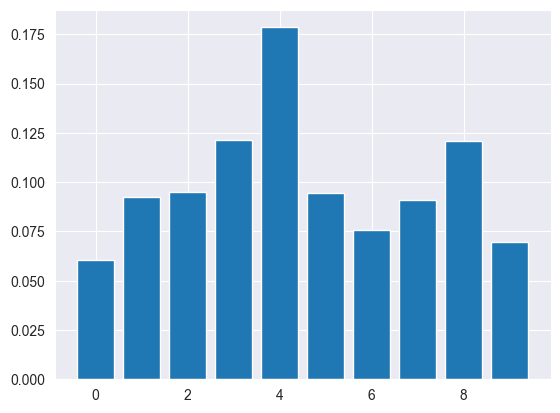

In [61]:
importance = clsf1.feature_importances_
for i,v in enumerate(importance):
    print(f"Feature: {i}, Score: {v}")

plt.bar([x for x in range(len(importance))], importance)
plt.show()

6. Folosind această metodă de procesare a textelor, antrenați alte doua modele diferite la alegere și comparati performanța cu modelul original.

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(5)
knc.fit(x_train1, y_train1)
y_test_predict = knc.predict(x_test1)
print("K Neighbors Classifier Accuracy:", metrics.accuracy_score(y_test1, y_test_predict))

rfc = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10)
rfc.fit(x_train1, y_train1)
y_test_predict = rfc.predict(x_test1)
print("Random Forest Classifier Accuracy:", metrics.accuracy_score(y_test1, y_test_predict))


K Neighbors Classifier Accuracy: 0.2852858856457417
Random Forest Classifier Accuracy: 0.3230707716913235


7. Pentru cel mai bun model afisați metricile la nivel de clasă (classification report) și matricea de confuzie.

              precision    recall  f1-score   support

           0       0.41      0.29      0.34      1033
           1       0.32      0.11      0.17      1009
           2       0.30      0.80      0.43      1244
           3       0.52      0.13      0.21       945
           4       0.47      0.21      0.29       771

    accuracy                           0.34      5002
   macro avg       0.40      0.31      0.29      5002
weighted avg       0.40      0.34      0.30      5002



<Axes: >

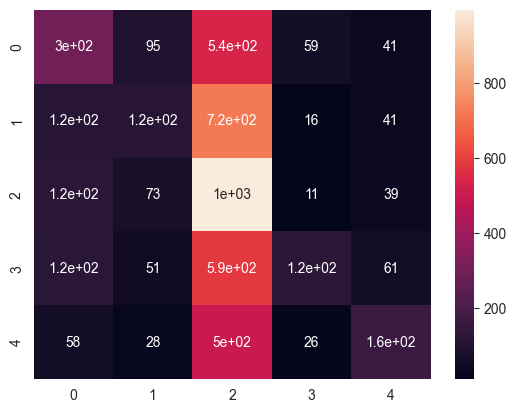

In [64]:
y_test_predict = clsf1.predict(x_test1)
print(metrics.classification_report(y_test1, y_test_predict, zero_division=True))
matrix = metrics.confusion_matrix(y_test1, y_test_predict)
sns.heatmap(matrix, annot=True)
